In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import corner
from models.classifier import BinaryClassifier
import torch
from torch.utils.data import TensorDataset
from tqdm.auto import trange
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


In [255]:
class Galton():
    def __init__(self, n_steps, odds_right, n_dims=1, noise=False, sigma=0.1):
        self.n_steps = n_steps
        self.n_dims = n_dims
        if odds_right > 1 or odds_right < 0:
            print("Odds of landing on the right must be less than 1 and greater than 0")
        self.odds_right = odds_right
        self.noise = noise
        self.sigma = sigma

    
    def simulate(self, n_balls):
        """
        Simulate the Galton board
        """
        #initialize position of the balls at x=0
        pos = np.zeros((int(n_balls), self.n_dims))

        # np.random.seed(0)
        #multiply n_steps by 2 and divide pos by 2 to avoid empty bins (only odd or only even)
        for step in range(self.n_steps*2):
            #generate a random number between 0 and 1
            r = np.random.random((int(n_balls), self.n_dims), )
            #if the random number is less than the odds of landing on the right,
            #then the ball lands on the right
            pos[r < self.odds_right] += 1
            pos[r >= self.odds_right] -= 1

        if self.noise:
            if self.sigma is None:
                noise = np.random.normal(0, 2/np.sqrt(self.n_steps), (int(n_balls), self.n_dims))
            else:
                noise = np.random.normal(0, self.sigma, (int(n_balls), self.n_dims))
            pos += noise

        return pos.squeeze()/2.0/np.sqrt(self.n_steps)


In [4]:
n_steps_big = 30
n_steps_small = 5
# bins_big = np.linspace(-n_steps_big-0.5, n_steps_big+0.5, 2*n_steps_big+2)
g_big = Galton(n_steps=n_steps_big, odds_right=0.5, n_dims=1)
# bins_small = np.linspace(-n_steps_small-0.5, n_steps_small+0.5, 2*n_steps_small+2)
g_small = Galton(n_steps=n_steps_small, odds_right=0.6, n_dims=1)

In [4]:
n_balls_big = 1.e4
n_balls_small = 1.e4
pos_big = g_big.simulate(n_balls=n_balls_big)
pos_small = g_small.simulate(n_balls=n_balls_small)

In [5]:
pos_big.shape
pos_small.shape

(10000,)

In [6]:
bins = np.linspace(-3,3,6)

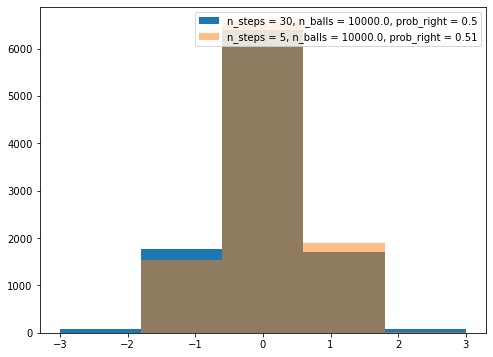

In [96]:
plt.figure(figsize=(8,6))
plt.hist(pos_big, bins=bins,label="n_steps = {}, n_balls = {}, prob_right = {}".format(n_steps_big, n_balls_big, g_big.odds_right))
plt.hist(pos_small, bins=bins, label="n_steps = {}, n_balls = {}, prob_right = {}".format(n_steps_small, n_balls_small, g_small.odds_right), alpha=0.5)
plt.legend()
plt.show()

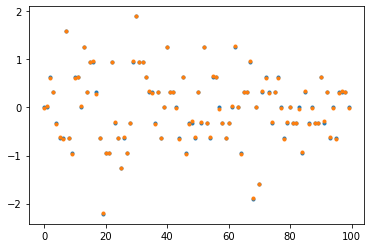

In [242]:
g = Galton(n_steps=10, odds_right=0.5, n_dims=1, sigma=0)
g_noise = Galton(n_steps=10, odds_right=0.5, n_dims=1, noise=True)
pos = g.simulate(n_balls=100)
pos_noise = g_noise.simulate(n_balls=100)
plt.plot(pos, ".", label="No noise")
plt.plot(pos_noise, ".", label="With noise")

## Binary Classifier

In [31]:
Nsims = 100

n_balls_big = 1.e2
n_balls_small = 1.e2

pos_big_arr = np.array([g_big.simulate(n_balls=n_balls_big) for _ in range(Nsims)])
pos_small_arr = np.array([g_small.simulate(n_balls=n_balls_small) for _ in range(Nsims)])

In [32]:
data = torch.cat((torch.from_numpy(pos_big_arr).float().reshape(-1,1), torch.from_numpy(pos_small_arr).float().reshape(-1,1)))
labels = torch.cat([torch.zeros(pos_big_arr.shape[0]*pos_big_arr.shape[1]), torch.ones(pos_small_arr.shape[0]*pos_small_arr.shape[1])])
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.1) 

In [20]:
# Parameters
params = {'batch_size': 512,
          'shuffle': True}

# Generators
data_set_train = TensorDataset(data_train, labels_train)
data_generator_train = torch.utils.data.DataLoader(data_set_train, **params)

# data_set_test = TensorDataset(data_test, labels_test)
# data_generator_test = torch.utils.data.DataLoader(data_set_test, **params)

In [21]:
# classifier = BinaryClassifier(np.shape(pos_big_arr)[1])
classifier = BinaryClassifier(1)
optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-3, weight_decay=1e-4)

In [22]:
n_steps = 1000
classifier_loss = []

classifier.train()
for n_step in trange(n_steps):
    data, labels = next(iter(data_generator_train))
    
    optimizer.zero_grad()

    loss = classifier.loss(data, labels).mean()
    classifier_loss.append(loss.item())

    loss.backward()
    optimizer.step()
classifier.eval();

100%|██████████| 1000/1000 [00:03<00:00, 252.09it/s]


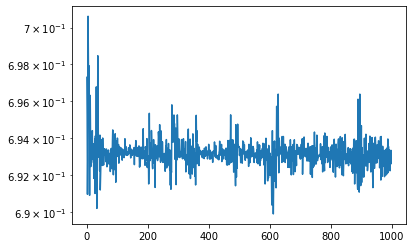

In [23]:
plt.plot(classifier_loss)
plt.yscale('log')

## Classifier Picking up on unfairness

In [200]:
odds_arr = [0.5, 0.51, 0.55, 0.7]
Nsims = 100
n_balls = 1.e2
n_steps = 1000
accuracy_score_arr = []

for odds in odds_arr:
    g_big = Galton(n_steps=10, odds_right=0.5, n_dims=1) #Don't need to re-initialize this but w/e
    g_small = Galton(n_steps=10, odds_right=odds, n_dims=1)
    pos_big_arr = np.array([g_big.simulate(n_balls=n_balls) for _ in range(Nsims)])
    pos_small_arr = np.array([g_small.simulate(n_balls=n_balls_small) for _ in range(Nsims)])

    data = torch.cat((torch.from_numpy(pos_big_arr).float().reshape(-1,1), torch.from_numpy(pos_small_arr).float().reshape(-1,1)))
    labels = torch.cat([torch.zeros(pos_big_arr.shape[0]*pos_big_arr.shape[1]), torch.ones(pos_small_arr.shape[0]*pos_small_arr.shape[1])])
    data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.1) 

    data_set_train = TensorDataset(data_train, labels_train)
    data_generator_train = torch.utils.data.DataLoader(data_set_train, **params)

    classifier = BinaryClassifier(1, activation="ReLU")
    optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-2, weight_decay=1e-4) 
    
    classifier.train()
    classifier_loss=[]
    for n_step in trange(n_steps):
        data, labels = next(iter(data_generator_train))
        
        optimizer.zero_grad()

        loss = classifier.loss(data, labels).mean()
        classifier_loss.append(loss.item())

        loss.backward()
        optimizer.step()
    classifier.eval();
    accuracy_score_arr.append(((classifier.forward(data_test) > 0.0) == labels_test).float().mean())
    

100%|██████████| 1000/1000 [00:02<00:00, 407.85it/s]


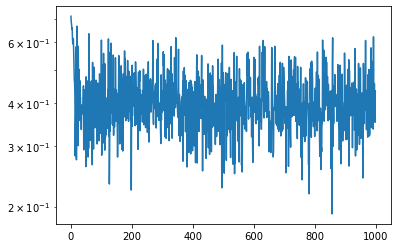

In [179]:
plt.plot(classifier_loss)
plt.yscale('log')

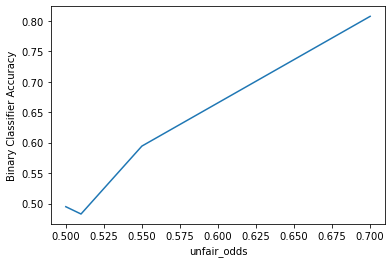

In [180]:
plt.plot(odds_arr, accuracy_score_arr)
plt.xlabel("unfair_odds")
plt.ylabel("Binary Classifier Accuracy")
plt.show()

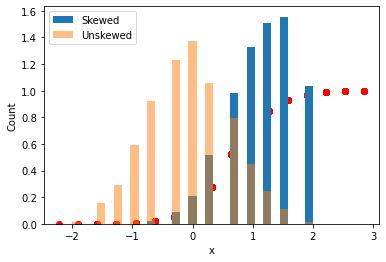

In [203]:
plt.hist(np.array(data_test[labels_test==1]),bins=np.linspace(-2,2,30), label="Skewed", density=True)
plt.hist(np.array(data_test[labels_test==0]),bins=np.linspace(-2,2,30),alpha=0.5, label="Unskewed", density=True)
plt.xlabel("x")
plt.ylabel("Count")
plt.legend()
plt.scatter(data_test.detach().numpy(), classifier.forward(data_test).sigmoid().detach().numpy(), color="red")

## Classifier finding resolution

In [181]:
params = {'batch_size': 256,
          'shuffle': True}

In [185]:
n_rows_arr = [5, 10, 100, 500]
n_rows_low = 5
Nsims = 100
n_balls = 1e2
accuracy_score_arr = []
n_steps = 2000

for n_rows in n_rows_arr:
    g_big = Galton(n_steps=n_rows_low, odds_right=0.5, n_dims=1) 
    g_small = Galton(n_steps=n_rows, odds_right=0.5, n_dims=1)
    
    pos_big_arr = np.array([g_big.simulate(n_balls=n_balls) for _ in range(Nsims)])
    pos_small_arr = np.array([g_small.simulate(n_balls=n_balls) for _ in range(Nsims)])

    data = torch.cat((torch.from_numpy(pos_big_arr).float().reshape(-1,1), torch.from_numpy(pos_small_arr).float().reshape(-1,1)))
    labels = torch.cat([torch.zeros(pos_big_arr.shape[0]*pos_big_arr.shape[1]), torch.ones(pos_small_arr.shape[0]*pos_small_arr.shape[1])])
    data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.1) 

    data_set_train = TensorDataset(data_train, labels_train)
    data_generator_train = torch.utils.data.DataLoader(data_set_train, **params)

    classifier = BinaryClassifier(1,activation="ReLU")
    optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-3, weight_decay=1e-4) 
    
    classifier.train()
    classifier_loss = []
    for n_step in trange(n_steps):
        data, labels = next(iter(data_generator_train))
        
        optimizer.zero_grad()

        loss = classifier.loss(data, labels).mean()
        classifier_loss.append(loss.item())

        loss.backward()
        optimizer.step()
    classifier.eval();
    accuracy_score_arr.append(((classifier.forward(data_test) > 0.0) == labels_test).float().mean())
    

100%|██████████| 2000/2000 [00:04<00:00, 435.20it/s]


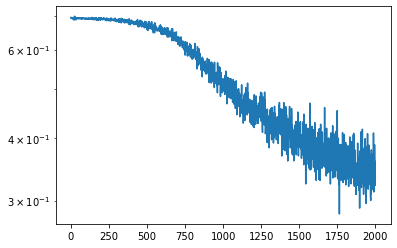

In [186]:
plt.plot(classifier_loss)
plt.yscale('log')

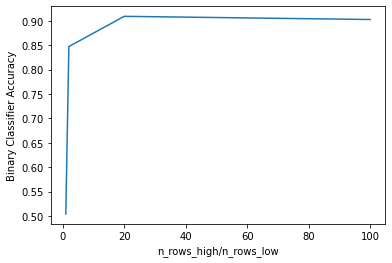

In [187]:
plt.plot(np.array(n_rows_arr)/5.0, accuracy_score_arr)
plt.xlabel("n_rows_high/n_rows_low")
plt.ylabel("Binary Classifier Accuracy")
plt.show()

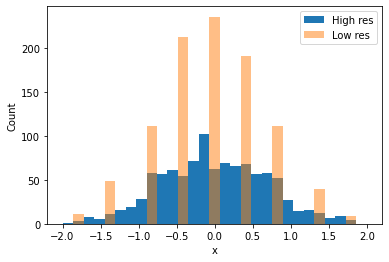

In [194]:
plt.hist(np.array(data_test[labels_test==1]),bins=np.linspace(-2,2,30), label="High res")
plt.hist(np.array(data_test[labels_test==0]),bins=np.linspace(-2,2,30),alpha=0.5, label="Low res")
plt.xlabel("x")
plt.ylabel("Count")
plt.legend()
plt.show()

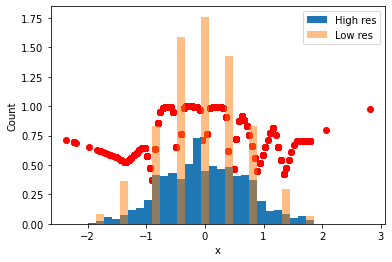

In [199]:
plt.hist(np.array(data_test[labels_test==1]),bins=np.linspace(-2,2,30), label="High res", density=True)
plt.hist(np.array(data_test[labels_test==0]),bins=np.linspace(-2,2,30),alpha=0.5, label="Low res", density=True)
plt.xlabel("x")
plt.ylabel("Count")
plt.legend()
plt.scatter(data_test.detach().numpy(), classifier.forward(data_test).sigmoid().detach().numpy(), color="red")

## Generate Split Data (Manually)

### Complete correlation between skewness and resolution (alpha=1)

In [348]:
Nsims = 100
n_balls = 1e2
n_high_steps = 20
n_low_steps = 5
odds_skew = 0.55

g_high_skew = Galton(n_steps=n_high_steps, odds_right=odds_skew, n_dims=1,noise=True) 
g_high_unskew = Galton(n_steps=n_high_steps, odds_right=0.5, n_dims=1,noise=True)
g_low_skew = Galton(n_steps=n_low_steps, odds_right=odds_skew, n_dims=1,noise=True)
g_low_unskew = Galton(n_steps=n_low_steps, odds_right=0.5, n_dims=1,noise=True)

pos_high_skew_arr = np.array([g_high_skew.simulate(n_balls=n_balls) for _ in range(Nsims)])
pos_high_unskew_arr = np.array([g_high_unskew.simulate(n_balls=n_balls) for _ in range(Nsims)])
pos_low_skew_arr = np.array([g_low_skew.simulate(n_balls=n_balls) for _ in range(Nsims)])
pos_low_unskew_arr = np.array([g_low_unskew.simulate(n_balls=n_balls) for _ in range(Nsims)])

#for alpha=1, want complete correlation between resolution and skewness.
data = torch.cat((torch.from_numpy(pos_high_skew_arr).float().reshape(-1,1), torch.from_numpy(pos_low_unskew_arr).float().reshape(-1,1)))
labels = torch.cat([torch.zeros(pos_high_skew_arr.shape[0]*pos_high_skew_arr.shape[1]), torch.ones(pos_low_unskew_arr.shape[0]*pos_low_unskew_arr.shape[1])])

data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.1) 
# Parameters
params = {'batch_size': 128,
          'shuffle': True}

# Generators
data_set_train = TensorDataset(data_train, labels_train)
data_generator_train = torch.utils.data.DataLoader(data_set_train, **params)

classifier = BinaryClassifier(1, activation="ReLU")
optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-4, weight_decay=1e-4)

In [349]:
#RUN CLASSIFIER
n_steps_train = 10000

classifier.train()
classifier_loss = []
for n_step in trange(n_steps_train):
    data, labels = next(iter(data_generator_train))
    
    optimizer.zero_grad()

    loss = classifier.loss(data, labels).mean()
    classifier_loss.append(loss.item())

    loss.backward()
    optimizer.step()
classifier.eval();
print("Binary Classifier Accuracy: ", ((classifier.forward(data_test) > 0.0) == labels_test).float().mean().item())

100%|██████████| 10000/10000 [00:16<00:00, 611.60it/s]

Binary Classifier Accuracy:  0.7260000109672546


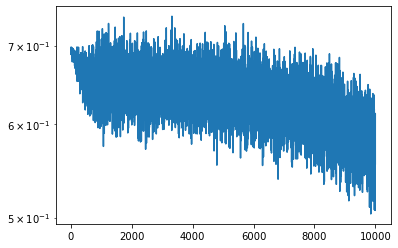

In [350]:
plt.plot(classifier_loss)
plt.yscale('log')

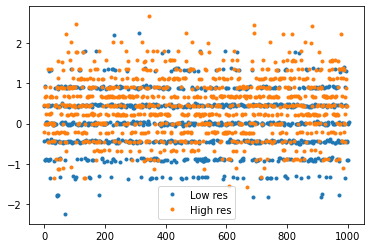

In [351]:
plt.plot(np.array(data_test[labels_test==1]),'.',label="Low res")
plt.plot(np.array(data_test[labels_test==0]), '.', label="High res")
plt.legend()
plt.show()

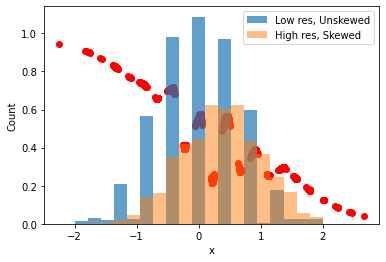

In [396]:
plt.hist(np.array(data_test[labels_test==1]),bins=np.linspace(-2,2,20), alpha=0.7, label="Low res, Unskewed", density=True)
plt.hist(np.array(data_test[labels_test==0]),bins=np.linspace(-2,2,20),alpha=0.5, label="High res, Skewed", density=True)
plt.xlabel("x")
plt.ylabel("Count")
plt.legend()
plt.scatter(data_test.detach().numpy(), classifier.forward(data_test).sigmoid().detach().numpy(), color='red')

In [385]:
counter_data = torch.cat((torch.from_numpy(pos_low_skew_arr).float().reshape(-1,1), torch.from_numpy(pos_high_unskew_arr).float().reshape(-1,1)))
counter_labels = torch.cat([torch.zeros(pos_low_skew_arr.shape[0]*pos_low_skew_arr.shape[1]), torch.ones(pos_high_unskew_arr.shape[0]*pos_high_unskew_arr.shape[1])])

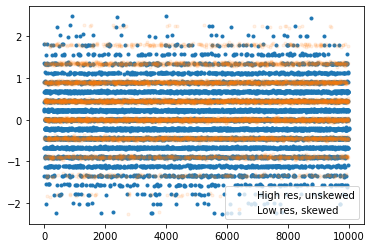

In [392]:
plt.plot(np.array(counter_data[counter_labels==1].reshape(-1,1)),'.',label="High res, unskewed")
plt.plot(np.array(counter_data[counter_labels==0].reshape(-1,1)),'.',label="Low res, skewed", alpha=0.1)
plt.legend()
plt.show()

In [393]:
print("Binary Classifier Accuracy: ", ((classifier.forward(counter_data) > 0.0) == counter_labels).float().mean().item())

Binary Classifier Accuracy:  0.4064500033855438


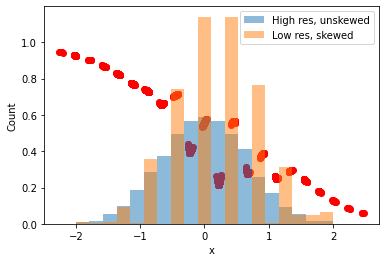

In [395]:
plt.hist(np.array(counter_data[counter_labels==1]), bins=np.linspace(-2,2,20), label="High res, unskewed", alpha=0.5, density=True)
plt.hist(np.array(counter_data[counter_labels==0]), bins=np.linspace(-2,2,20), label="Low res, skewed", alpha=0.5, density=True)
plt.xlabel("x")
plt.ylabel("Count")
plt.legend()
plt.scatter(high_unskew_dat.detach().numpy(), classifier.forward(high_unskew_dat).sigmoid().detach().numpy(), color='red')

### Splitting Samples (Not working)

In [249]:
def split_samples(alpha, beta, samples0_0, samples0_1, samples1_0, samples1_1):
    """
    Calculate the number of samples from each probability for a given alpha, beta, and Ntot in order to have equal numbers of samples from
    each resolution (assuming n_prob1_highres = n_prob1_lowres, n_prob2_highres = n_prob2_lowres)

    Inputs: 
    alpha - label splitting parameter
    beta - sensitive attribute splitting parameter
    Ntot - total number of samples
    samples0_0 - samples from the first probability with sensitive attribute 0
    samples0_1 - samples from the first probability with sensitive attribute 1
    samples1_0 - samples from the second probability with sensitive attribute 0
    samples1_1 - samples from the second probability with sensitive attribute 1

    Returns: total samples
    """
    if len(samples0_0) != len(samples0_1) or len(samples0_0) != len(samples1_0) or len(samples0_0) != len(samples1_1) or \
    len(samples0_1) != len(samples1_0) or len(samples0_1) != len(samples1_1) or len(samples1_0) != len(samples1_1):
        print("Error: the number of samples from each probability must be the same")
        return 0

    n = len(samples0_0) 

    samples_low = np.concatenate((np.random.choice(samples0_0, round(n*alpha)), np.random.choice(samples1_0, round(n*(1-alpha)))))
    
    samples_high = np.concatenate((np.random.choice(samples0_1, round(n*alpha)), np.random.choice(samples1_1, round(n*(1-alpha)))))

    samples_tot = np.concatenate((np.random.choice(samples_low, round(n*beta)), np.random.choice(samples_high, round(n*(1-beta)))))
    
    return samples_tot

In [250]:
samples0_0 = np.random.uniform(0,1,10)
samples0_1 = np.random.uniform(0,1,10)
samples1_0 = np.random.uniform(-1,0,10)
samples1_1 = np.random.uniform(-1,0,10)

split_samples(0.5, 0.5, samples0_0, samples0_1, samples1_0, samples1_1)

array([-0.16368915,  0.12314658, -0.19718988, -0.19718988,  0.12314658,
        0.41154107,  0.18569382,  0.41154107,  0.01859128, -0.93851458])

<!-- run N dimensional galton board. Independent runs -->
Testing 
Run binary classifier to see if skewed
plot classifier output vs x for relative resolutions

In [258]:
#     #! This version is outdated I think
# def label_sample_split(alpha, beta, Ntot, samples0_0, samples0_1, samples1_0, samples1_1):
#     """
#     Calculate the number of samples from each probability for a given alpha, beta, and Ntot in order to have equal numbers of samples from
#     each resolution (assuming n_prob1_highres = n_prob1_lowres, n_prob2_highres = n_prob2_lowres)

#     Inputs: 
#     alpha - label splitting parameter
#     beta - sensitive attribute splitting parameter
#     Ntot - total number of samples
#     samples0_0 - samples from the first probability with sensitive attribute 0
#     samples0_1 - samples from the first probability with sensitive attribute 1
#     samples1_0 - samples from the second probability with sensitive attribute 0
#     samples1_1 - samples from the second probability with sensitive attribute 1

#     Returns: total samples
#     """

#     #todo: add special cases for alpha = 0 and beta = 0 etc.

#     # if alpha==0.5: #All samples are from the first probability
#     #     n0 = Ntot/2
#     #     n1 = 0
#     # elif beta==1: #All samples are from the first sensitive attribute
#     #     n0 = samples0_0
#     #     n1 = samples0_1
#     # elif beta==0: #All samples are from the second sensitive attribute
#     #     n0 = samples1_0
#     #     n1 = samples1_1
#     # else:
#     n0 = Ntot*(1 - alpha - beta) / (2.0*(2*alpha-1)*(beta**2 - beta))
#     n1 = n0 * (alpha-beta)/(alpha + beta - 1)

#     data_0 = np.concatenate((np.random.choice(samples0_0, round(n0*alpha)), np.random.choice(samples1_0, round(n1*(1-alpha))))) #data with sensitive attribute 0
#     data_1 = np.concatenate((np.random.choice(samples0_1, round(n0*(1-alpha))), np.random.choice(samples1_1, round(n1*alpha)))) #data with sensitive attribute 1


#     return np.concatenate((np.random.choice(data_0,round(beta*Ntot)), np.random.choice(data_1,round((1-beta)*Ntot))))

sensitive: number of steps
label: probablities
4 boards, equally weighted. Fraction of 50/50 high res.

num5050 = num6040


<!-- Not these!! -->
<!-- num5050_30 = num5050_5
num6040_30 = num6040_5 -->

datansteps30 = (alpha)num505030 + (1-alpha)num604030
datansteps5 = (1-alpha)num50505 + (alpha)num60405

<!-- datansteps30 = (alpha)num505030 + (1-alpha)num604030
datansteps5 = (alpha)num50505 + (1-alpha)num60405 -->

datatot = (beta)datansteps30 + (1-beta)datansteps5

datatot needs to have equal numbers of 5050 vs 6040 samples

In [ ]:
beta*(alpha*num_50 + (1-alpha)num_60) = (1-beta)((1-alpha)num_50 + (alpha)num_60)

Create a dataset that has certain values of alpha and beta
alpha=1 (completely correlated. See if it can classify the opposite case)
alpha=0.5 case?